In [1]:
import os
import sys

sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
le = LabelEncoder()

import scipy

orig_df = pd.read_hdf("../data_extract/features_dataset_2b.h5")
from pymir import *

In [2]:
NUM_PEOPLE = 40
df = orig_df.loc[orig_df['id']<NUM_PEOPLE]

In [3]:
p1 = df.loc[df['id']==0]
p2 = df.loc[df['id']==1]
chlist = ["chroma{}".format(i) for i in range(12)]

In [4]:
mean = np.mean(p1[chlist], axis = 0)
var = np.var(p1[chlist], axis = 0)
tmean = np.mean(p2[chlist], axis = 0)
tvar = np.var(p2[chlist], axis = 0)

In [8]:
def modify_spectrum(spectrum, mean, var, tmean, tvar):
    
    chroma = [0] * 12
    
    for index in range(0, len(spectrum)):
        # Assign a frequency value to each bin
        f = index * (spectrum.sampleRate / 2.0) / len(spectrum)
        # Convert frequency to pitch to pitch class
        if f != 0:
            pitch = Pitch.frequencyToMidi(f)
        else:
            pitch = 0
        pitchClass = pitch % 12
        chroma[pitchClass] = chroma[pitchClass] + abs(spectrum[index])
#         print(pitchClass , f)
    
    # Normalize the chroma vector
    norm = sum(chroma)
    chroma = [c / norm for c in chroma]
    
#     spectrum2 = np.array()
    for index2 in range(0, len(spectrum)):
        index = len(spectrum) - index2 - 1
        # Assign a frequency value to each bin
        f = index * (spectrum.sampleRate / 2.0) / len(spectrum)
        # Convert frequency to pitch to pitch class
        if f != 0:
            pitch = Pitch.frequencyToMidi(f)
        else:
            pitch = 0
        pitchClass = pitch % 12
        wt = abs(spectrum[index]) / chroma[pitchClass]
        wt = wt / norm
        
        ## Code for shifting frequency
        shift = 500
        if index > shift:
            spectrum[index] = spectrum[index-shift]
        else:
            spectrum[index] = 0
    
        ## Code for Chroma manipulation
#         spectrum[index] = (spectrum[index] - wt*mean[pitchClass]) /( wt*var[pitchClass])
#         spectrum[index] = (spectrum[index]*wt*tvar[pitchClass]) + wt*tmean[pitchClass]
#         spectrum[index] = (spectrum[index] - wt*mean[pitchClass])
#         spectrum[index] = spectrum[index] + (index * 0.0001)

In [9]:
filepath1 = "../data/dev-clean/" + p1.iloc[0]['pid']+"/"+p1.iloc[0]['chname']+"/"+p1.iloc[100]['fname']
targetvoice = "../data/dev-clean/" + p2.iloc[0]['pid']+"/"+p2.iloc[0]['chname']+"/"+p2.iloc[100]['fname']
outputpath = "../outputs/transformed_voice_demo.wav"
def modify():
    print(filepath1)
    adata = AudioFile.open(filepath1)

    segments = adata.frames(2000000)
        
    spectra = [segment.spectrum() for segment in segments]
    
    plt.plot(spectra[0])
    
    for spectrum in spectra:
        modify_spectrum(spectrum, mean, var, tmean, tvar)
   
    plt.plot(spectra[0])
    
    fdata = np.array([item for spectrum in spectra for item in Transforms.ifft(spectrum)])
    scaled = np.int16(fdata * 32767.0)
    scipy.io.wavfile.write(outputpath, spectra[0].sampleRate, scaled)

../data/dev-clean/1272/135031/1272-135031-0011.wav


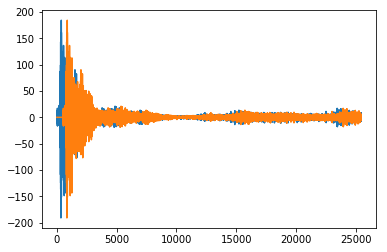

In [10]:
modify()
import IPython
IPython.display.Audio(outputpath)
IPython.display.Audio(filepath1)
IPython.display.Audio(targetvoice)